# Establish Need for Improvement over Baselines.

## Q1: Given heterogeneous behaviors as input, how does the homogeneous embedding model from Mattson and Brown [2] embed these behaviors?

In [4]:
"""
Externals
"""
import torch
import numpy as np
from novel_swarms.results.results import main as base_results
from novel_swarms.config.defaults import ConfigurationDefaults
from novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from data.swarmset import SwarmDataset
from src.networks.network_wrapper import NetworkWrapper
from src.training.labels import LabelSet
from src.constants import SINGLE_SENSOR_WORLD_CONFIG, TWO_SENSOR_WORLD_CONFIG
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

"""
Import Pretrained Model
"""
arch = NoveltyArchive()
network = NetworkWrapper(output_size=5, margin=1.0, new_model=True)
network.load_from_path("../../../checkpoints/ensembles/01-27-23-BLH-HIL-G/0.pt")
network.eval_mode()

pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
Adjusting learning rate of group 0 to 1.0000e-05.


In [51]:
"""
Q4 Assumes that there was a linearly compiled dataset (see create_dataset.py)
"""
out = ""
NUM_PER = 1
for i in range(18):
    for j in range(NUM_PER):
        out += f"{(i * NUM_PER) + j}, {i}\n"

with open("../../../data/oracle/mrs-q6-labels.txt", "w") as f:
    f.write(out)

In [12]:
"""
Load Data
"""
heterogeneous_dataset = SwarmDataset("../../../data/mrs-q4-samples", rank=0)
labels = LabelSet("../../../data/oracle/mrs-q4-labels.txt")

In [47]:
"""
Embed
"""

heterogeneous_archive = NoveltyArchive()
for i in range(len(heterogeneous_dataset)):
    image, controller, behavior = heterogeneous_dataset[i][0], heterogeneous_dataset[i][1], heterogeneous_dataset[i][2]
    image = np.expand_dims(image, axis=0)
    embed = network.batch_out(image)
    embed = embed.detach().cpu().squeeze(dim=0).numpy()

    # Uncomment for Network Analysis (Mattson & Brown)
    # heterogeneous_archive.addToArchive(embed, controller)

    # Uncomment for B-Vector Analysis (Brown et al.)
    if not np.isnan(np.sum(behavior)):
        heterogeneous_archive.addToArchive(behavior, controller)

classes = ["Segments", "Nucleus", "Containment", "Spiral", "Nested Cycles", "Perimeter", "Site Traversal", "Flail", "Hurricane", "Snake", "Leader", "Dipole", "Aggregation", "Cyclic Pursuit", "Dispersal", "Milling", "Wall Following", "Random"]
print(labels.color_map)
labels.set_color(17, (0.8, 0.8, 0.8))

colors = labels.get_colors()
l = [classes[i] for i in labels.get_labels()]
embeddings = heterogeneous_archive.archive

{0: (1.0, 0.7019607843137254, 0.0), 1: (0.5019607843137255, 0.24313725490196078, 0.4588235294117647), 2: (1.0, 0.40784313725490196, 0.0), 3: (0.6509803921568628, 0.7411764705882353, 0.8431372549019608), 4: (0.7568627450980392, 0.0, 0.12549019607843137), 5: (0.807843137254902, 0.6352941176470588, 0.3843137254901961), 6: (0.5058823529411764, 0.4392156862745098, 0.4), 7: (0.0, 0.49019607843137253, 0.20392156862745098), 8: (0.9647058823529412, 0.4627450980392157, 0.5568627450980392), 9: (0.0, 0.3254901960784314, 0.5411764705882353), 10: (1.0, 0.47843137254901963, 0.3607843137254902), 11: (0.3254901960784314, 0.21568627450980393, 0.47843137254901963), 12: (1.0, 0.5568627450980392, 0.0), 13: (0.7019607843137254, 0.1568627450980392, 0.3176470588235294), 14: (0.9568627450980393, 0.7843137254901961, 0.0), 15: (0.4980392156862745, 0.09411764705882353, 0.050980392156862744), 16: (0.5764705882352941, 0.6666666666666666, 0.0), 17: (0.8, 0.8, 0.8)}


In [48]:
"""
Dimensionality Reduction (t-SNE)
"""
reduced = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    perplexity=7,
    early_exaggeration=2
).fit_transform(embeddings)

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


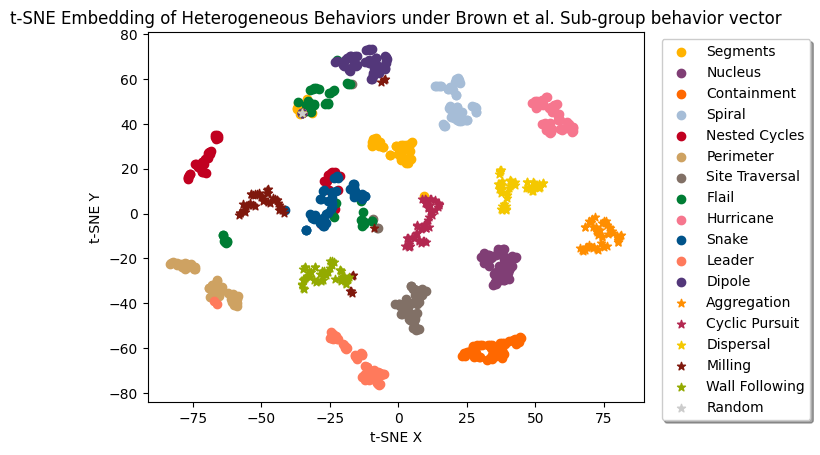

In [50]:
"""
Visualize (MatPlotLib)
"""
lim = len(embeddings)
x = [reduced[i][0] for i in range(lim)]
y = [reduced[i][1] for i in range(lim)]

for _x, _y, _l, _c in zip(x, y, labels.get_labels(), colors):
    plt.scatter(_x, _y, c=[_c], cmap="rgb", marker="o" if _l < 12 else "*")

# Add Legend Labels (Hacky)
for i in range(len(classes)):
    plt.scatter(x[0], y[0], c=[list(labels.color_map.values())[i]], label=classes[i], marker="o" if i < 12 else "*")

plt.title("t-SNE Embedding of Heterogeneous Behaviors under Brown et al. Sub-group behavior vector")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0),
          ncol=1, fancybox=True, shadow=True)
plt.show()